## A/B tests с Python

### Урок 9. Python применение продвинутых методов

#### Задание: Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.
Mobile Games AB Testing with Cookie Cats.

Cookie Cats — чрезвычайно популярная мобильная игра-головоломка, разработанная Tactile Entertainment. По мере прохождения уровней игры игроки будут время от времени сталкиваться с воротами, которые заставят их ждать нетривиальное количество времени или совершать покупки в приложении для прохождения. Помимо стимулирования покупок в приложении, эти ворота служат важной цели, давая игрокам принудительный перерыв в игре, что, как мы надеемся, приведет к увеличению и продлению удовольствия игрока от игры. Но где должны быть расположены ворота? Первоначально первые ворота были размещены на уровне 30, но в этой записной книжке мы собираемся проанализировать AB-тест, в котором мы переместили первые ворота в Cookie Cats с уровня 30 на уровень 40. В частности, мы рассмотрим влияние на удержание игроков. Но прежде чем мы доберемся до этого, ключевым шагом перед проведением любого анализа является понимание данных.

У нас есть данные от 90 189 игроков, которые установили игру во время проведения AB-теста. Переменные:
- userid - уникальный номер, который идентифицирует каждого игрока.
- версия - попал ли игрок в контрольную группу (gate_30 - ворота 30 уровня) или в группу с перемещенными воротами (gate_40 - ворота 40 уровня).
- sum_gamerounds - количество игровых раундов, сыгранных игроком в течение первых 14 дней после установки.
- удержания_1 - плеер вернулся и играл через 1 день после установки?
- удержания_7 - плеер вернулся и играл через 7 дней после установки?

Когда игрок устанавливал игру, он или она были случайным образом назначены либо к gate_30, либо к gate_40.

Итак, давайте загрузим его и посмотрим!

<a id="Libraries"></a>
##  Загрузка библиотек 

In [31]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

# Подготовка данных

In [32]:
data = pd.read_excel('результаты А_B.xlsx')

data.head(10)

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1
5,540,gate_40,187,1,1
6,1066,gate_30,0,0,0
7,1444,gate_40,2,0,0
8,1574,gate_40,108,1,1
9,1587,gate_40,153,1,0


Анализируем типы данных, отражаемой информации.

In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  int64 
 4   retention_7     90189 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 3.4+ MB


Количество строк и столбцов.

In [34]:
data.shape

(90189, 5)

Основные характеристики отображаемой по столбцам информации.

In [35]:
data.describe()

,userid,sum_gamerounds,retention_1,retention_7
count,9.018900e+04,90189.000000,90189.000000,90189.000000
mean,4.998412e+06,51.872457,0.445210,0.186065
std,2.883286e+06,195.050858,0.496992,0.389161
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.512230e+06,5.000000,0.000000,0.000000
50%,4.995815e+06,16.000000,0.000000,0.000000
75%,7.496452e+06,51.000000,1.000000,0.000000
max,9.999861e+06,49854.000000,1.000000,1.000000


Наличие пустых значений.

In [36]:
data.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

Количество игроков в выборках.

In [37]:
data.version.value_counts()

version
gate_40    45489
gate_30    44700
Name: count, dtype: int64

Количество игроков - уникальных ID

In [38]:
data.userid.nunique()

90189

Сумма игроков по выборкам равна итоговому количеству игроков. Пересекающихся данных нет.

Посмотрим на группы отдельно

In [39]:
data[data['version']=='gate_30'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.470000e+04,44700.000000,44700.000000,44700.000000
mean,4.987564e+06,52.456264,0.448188,0.190201
std,2.881026e+06,256.716423,0.497314,0.392464
min,1.160000e+02,0.000000,0.000000,0.000000
25%,2.505469e+06,5.000000,0.000000,0.000000
50%,4.983631e+06,17.000000,0.000000,0.000000
75%,7.481497e+06,50.000000,1.000000,0.000000
max,9.999710e+06,49854.000000,1.000000,1.000000


In [43]:
data[data['version']=='gate_40'].describe()

,userid,sum_gamerounds,retention_1,retention_7
count,4.548900e+04,45489.000000,45489.000000,45489.000000
mean,5.009073e+06,51.298776,0.442283,0.182000
std,2.885496e+06,103.294416,0.496663,0.385849
min,3.770000e+02,0.000000,0.000000,0.000000
25%,2.517171e+06,5.000000,0.000000,0.000000
50%,5.007329e+06,16.000000,0.000000,0.000000
75%,7.510762e+06,52.000000,1.000000,0.000000
max,9.999861e+06,2640.000000,1.000000,1.000000


Анализ выборок по уровням показывает, что на уровне 30 показатель среднего количества раундов выше, чем на уровне 40.

Кроме того, показатель максимального количества проведённых раундов и того более существенно выше на уровне 30.

### Проверка на нормальность распределения выборок по количеству сыгранных раундов

In [58]:
shapiro(data['version']=='gate_30')

ShapiroResult(statistic=0.6370958089828491, pvalue=0.0)

In [59]:
shapiro(data['version']=='gate_40')

ShapiroResult(statistic=0.636198878288269, pvalue=0.0)

In [56]:
from scipy.stats import kstest
print(kstest(data['sum_gamerounds'][data.version == 'gate_30'], 'norm'))
print(kstest(data['sum_gamerounds'][data.version == 'gate_40'], 'norm'))

KstestResult(statistic=0.8724176532867202, pvalue=0.0, statistic_location=2, statistic_sign=-1)
KstestResult(statistic=0.8707186187388001, pvalue=0.0, statistic_location=2, statistic_sign=-1)


Результаты тестов (Колмогорова-Смирнова и Шапиро-Уилка) показывают, что данные выборки не получены из генеральной совокупности с нормальным распределением.

### Непараметрический Хи-квадрат для вернувшихся после 1-го дня

In [89]:
n_cont = data[data['version'] == 'gate_30'].shape[0]
n_test = data[data['version'] == 'gate_40'].shape[0]

suc_cont = data[data['version'] == 'gate_30'].retention_1.sum()
suc_test = data[data['version'] == 'gate_40'].retention_1.sum()

print(n_cont, n_test)
print(suc_cont, suc_test)

44700 45489
20034 20119


In [90]:
from statsmodels.stats import proportion

In [91]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([suc_cont, suc_test]),
                                                   np.array([n_cont, n_test]))

print(f'Results are chisq = {round(chisq, 3)}, pvalue ={round(pvalue, 3)}')

Results are chisq = 3.183, pvalue =0.074


### Проверка с помощью z-критерия для долей (вернувшихся после 1-го дня)

In [92]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([suc_cont, suc_test]),
                                                   np.array([n_cont, n_test]))

print(f'Results are z_score = {round(z_score, 3)}, pvalue ={round(z_pvalue, 3)}')

Results are z_score = 1.784, pvalue =0.074


### Непараметрический Хи-квадрат для вернувшихся после 7-го дня

In [93]:
n_cont = data[data['version'] == 'gate_30'].shape[0]
n_test = data[data['version'] == 'gate_40'].shape[0]

suc_cont = data[data['version'] == 'gate_30'].retention_7.sum()
suc_test = data[data['version'] == 'gate_40'].retention_7.sum()

print(n_cont, n_test)
print(suc_cont, suc_test)

44700 45489
8502 8279


In [94]:
chisq, pvalue, table = proportion.proportions_chisquare(np.array([suc_cont, suc_test]),
                                                   np.array([n_cont, n_test]))

print(f'Results are chisq = {round(chisq, 3)}, pvalue ={round(pvalue, 3)}')

Results are chisq = 10.013, pvalue =0.002


### Проверка с помощью z-критерия для долей (вернувшихся после 7-го дня)

In [95]:
z_score, z_pvalue = proportion.proportions_ztest(np.array([suc_cont, suc_test]),
                                                   np.array([n_cont, n_test]))

print(f'Results are z_score = {round(z_score, 3)}, pvalue ={round(z_pvalue, 3)}')

Results are z_score = 3.164, pvalue =0.002


Результаты этих двух тестов подтверждают статистическую значимость качественных различий двух или нескольких относительных показателей для вернувшихся после 7-го дня, где р-value существенно меньше 5%. И отсутствие качественных различий для вернувшихся после 1-го дня, где р-value > 5%.

### Применяем метод Бутстрап для праверки влияния качества выборок.

Гипотезы:  
  
H0: Набор статистически значимо не влияет (p-value > 0.05)  
H1: Набор статистически значимо влияет (p-value < 0.05)  


In [61]:
import numpy as np
import pandas as pd
from scipy.stats import *
import matplotlib.pyplot as plt
from tqdm.auto import tqdm #для красивой полоски

plt.style.use('ggplot')

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 500, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_2), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"p_value": p_value}

  7%|▋         | 33/500 [00:00<00:01, 329.05it/s]

100%|██████████| 500/500 [00:01<00:00, 342.51it/s]


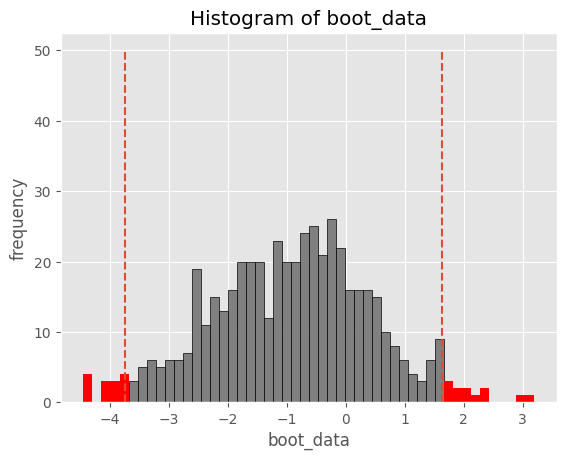

{'p_value': 0.4952566984812985}

In [62]:
get_bootstrap(data[(data['version'] == 'gate_30')&(data['retention_1'] > 0)]['sum_gamerounds'], data[(data['version'] == 'gate_40')&(data['retention_1'] > 0)]['sum_gamerounds'])

100%|██████████| 500/500 [00:00<00:00, 622.59it/s]


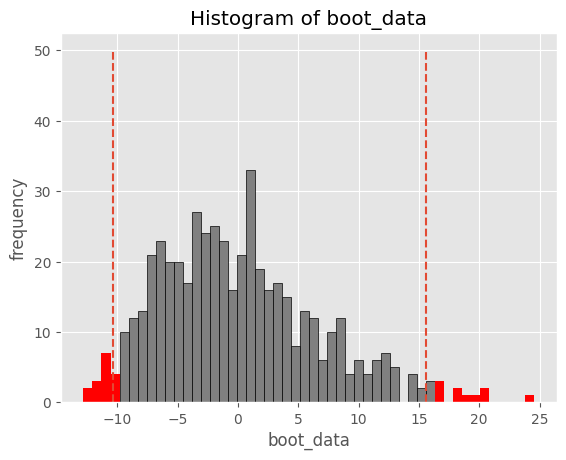

{'p_value': 0.9951654399378864}

In [63]:
get_bootstrap(data[(data['version'] == 'gate_30')&(data['retention_7'] > 0)]['sum_gamerounds'], data[(data['version'] == 'gate_40')&(data['retention_7'] > 0)]['sum_gamerounds'])

Тестирование качества выборки для игроков вернувшихся и после 1-го и после 7-го дня, показывает, что статистически значимых отличий в качестве выборок не обнаружено (p_value > 5%).

  2%|▏         | 12/500 [00:00<00:04, 119.13it/s]

100%|██████████| 500/500 [00:02<00:00, 179.98it/s]


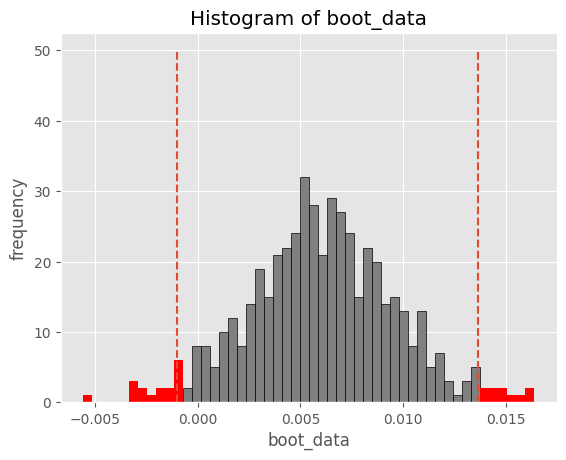

{'p_value': 0.089755655132677}

In [66]:
get_bootstrap(data[(data['version'] == 'gate_30')]['retention_1'], data[(data['version'] == 'gate_40')]['retention_1'])

  3%|▎         | 14/500 [00:00<00:03, 135.51it/s]

100%|██████████| 500/500 [00:02<00:00, 191.87it/s]


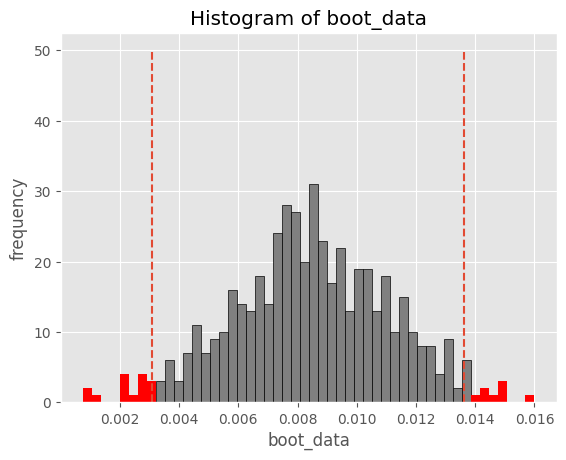

{'p_value': 0.0015121597598000119}

In [70]:
get_bootstrap(data[(data['version'] == 'gate_30')]['retention_7'], data[(data['version'] == 'gate_40')]['retention_7'])

Тестирование качества выборки для всех игроков и после 1-го и после 7-го дня, показывает, что статистически значимые отличия возникают в качестве выборок игроков после 7-го дня (p_value < 5%).

### Группировка по уровням и возвращениям в игру

In [81]:
data.groupby('version')['sum_gamerounds'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,52.456264,256.716423,0.0,5.0,17.0,50.0,49854.0
gate_40,45489.0,51.298776,103.294416,0.0,5.0,16.0,52.0,2640.0


In [96]:
data.groupby('version')['sum_gamerounds'].sum()

version
gate_30    2344795
gate_40    2333530
Name: sum_gamerounds, dtype: int64

In [83]:
data.groupby('version')['retention_1'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,0.448188,0.497314,0.0,0.0,0.0,1.0,1.0
gate_40,45489.0,0.442283,0.496663,0.0,0.0,0.0,1.0,1.0


In [99]:
data.groupby('version')['retention_1'].sum()

version
gate_30    20034
gate_40    20119
Name: retention_1, dtype: int64

In [100]:
data.groupby('version')['retention_7'].sum()

version
gate_30    8502
gate_40    8279
Name: retention_7, dtype: int64

In [84]:
data.groupby('version')['retention_7'].describe()

,count,mean,std,min,25%,50%,75%,max
version,,,,,,,,
gate_30,44700.0,0.190201,0.392464,0.0,0.0,0.0,0.0,1.0
gate_40,45489.0,0.182000,0.385849,0.0,0.0,0.0,0.0,1.0


In [82]:
data.groupby('retention_1')['version'].describe()

,count,unique,top,freq
retention_1,,,,
0,50036,2,gate_40,25370
1,40153,2,gate_40,20119


In [88]:
data.groupby('retention_7')['version'].describe()

,count,unique,top,freq
retention_7,,,,
0,73408,2,gate_40,37210
1,16781,2,gate_30,8502


Анализ в группировке по уровням и возвращениям показывает, что наибольшее возвращение после 7-го дня на уровне 30.

### Вывод: Наибольшее количество раундов в игре и наибольшее количество удержаний после 7-го дня происходит на уровне 30.